# Complex network measures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.path as mpath
import scipy.sparse
import time
from graph_tool.all import *

In [2]:
import matplotlib.tri as tri

def interpolate_irregular_data(x, y, z, xi, yi):
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    return zi

### Configurations

In [3]:
taumax2_subseas = 0

taumax8_subseas = 0

taumax16_subseas = 1

In [4]:
perc95 = 1
perc99 = 0
surr100 = 0
surr1000 = 1

In [5]:
if surr100:
    surr = '100'
elif surr1000:
    surr = '1000'

In [6]:
if perc95:
    perc = '95.0'
elif perc99:
    perc = '99.5'

In [7]:
file_path = '../data/'
file_grid_cells = 'grid_cell.txt'
file_lats_unreduced = file_path + 'lats.4dx4dy_ndjfm.txt'
file_lons_unreduced = file_path + 'lons.4dx4dy_ndjfm.txt'
 
if taumax2_subseas:
    file_path2 = file_path+'ES_taumax2_spatially_reduced/'

    #files to read
    file_name_sign_es = perc+'_'+'sign_es_subseas.taumax2.4dx4dy.ndjfm.spatiallyReduced.txt.npz'
    taumax = 2
    
elif taumax8_subseas:
    file_path2 = file_path+'ES_taumax8_spatially_reduced/'

    #files to read
    file_name_sign_es = perc+'_'+'sign_es_subseas.taumax8.4dx4dy.ndjfm.spatiallyReduced.txt.npz'
    taumax = 8


elif taumax16_subseas:
    file_path2 = file_path+'ES_taumax16_spatially_reduced/'

    #files to read
    file_name_sign_es = perc+'_'+'sign_es_subseas.taumax16.4dx4dy.ndjfm.spatiallyReduced.txt.npz'
    taumax = 16

### Reading Data and creating the complex network

In [8]:
if perc95:
    start_time = time.time()
    sign_es_list = []
    for i in range(100):
        sign_es_list.append(scipy.sparse.load_npz(file_path2+str(i)+'_'+file_name_sign_es))
    end_time = time.time()
    print('total time taken this code segment: ', end_time - start_time, ' s')

elif perc99:
    start_time = time.time()
    sign_es_list = []
    for i in range(100):
        sign_es_list.append(scipy.sparse.load_npz(file_path2+str(i)+'_'+file_name_sign_es))
    end_time = time.time()
    print('total time taken this code segment: ', end_time - start_time, ' s')  

total time taken this code segment:  1.119990348815918  s


In [9]:
start_time = time.time()
full_sign_es_csr = sum(sign_es_list)
end_time = time.time()
print('total time taken this code segment: ', (end_time - start_time)/60, ' min')

total time taken this code segment:  0.10280671914418539  min


In [10]:
full_sign_es_csr

<16197x16197 sparse matrix of type '<class 'numpy.float32'>'
	with 28552888 stored elements in Compressed Sparse Row format>

In [11]:
compl_net = full_sign_es_csr.toarray().astype(np.int32)

In [12]:
compl_net.shape

(16197, 16197)

### Identifying lon lat coordinates of Complex Network

In [13]:
lat_unreduced = np.loadtxt(file_lats_unreduced)
lon_unreduced = np.loadtxt(file_lons_unreduced)

In [14]:
lat_list = []
lon_list = []
counter = 0
with open(file_path+file_grid_cells, "r") as file:
    for line in file:
        # file_grid_cells specific tasks
        if counter > 2 and counter < 83:
            lon_list.append(np.array(line.split(' ')[:-1], dtype=np.float64))
        if counter > 84:
            lat_list.append(np.array(line.split(' ')[:-1], dtype=np.float64))
            
        counter+=1

In [15]:
lat = np.concatenate(lat_list, axis=0)
lon = np.concatenate(lon_list, axis=0)

In [16]:
lon_lat_list = []
for i in range(lat.shape[0]):
    lon_lat_list.append((lon[i], lat[i]))
lon_lat = np.array(lon_lat_list)

In [17]:
lon_lat

array([[-180.       ,    0.9836063],
       [-178.8715   ,    0.9836063],
       [-177.7429   ,    0.9836063],
       ...,
       [ 120.       ,   88.66436  ],
       [ 180.       ,   88.66436  ],
       [-180.       ,   89.78488  ]])

In [18]:
lon_lat.shape

(16197, 2)

### Creating the graphtool graph object

In [19]:
#creating a graphtool Graph
g = graph_tool.Graph()

g.add_vertex(compl_net.shape[0])

g.add_edge_list(np.transpose(compl_net.nonzero()))

In [20]:
g

<Graph object, directed, with 16197 vertices and 28552888 edges, at 0x7f6693726bd0>

### Degree

In [21]:
indegree = compl_net.sum(axis=1) #Verbindungen, die von allen anderen Knoten zum jeweiligen Knoten zeigen

In [22]:
outdegree = compl_net.sum(axis=0) #Verbindungen, die vom jeweiligen Knoten zu allen anderen Knoten zeigen

In [23]:
print(indegree.shape, outdegree.shape)

(16197,) (16197,)


In [24]:
in_and_out_degree = indegree + outdegree

In [25]:
in_and_out_degree.shape

(16197,)

In [26]:
in_and_out_degree_interp = interpolate_irregular_data(lon, lat, in_and_out_degree, lon_unreduced, lat_unreduced)

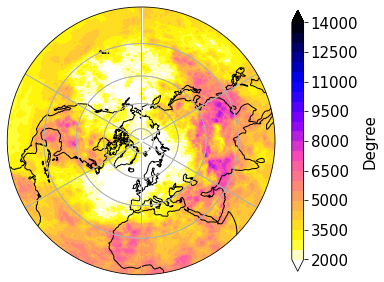

In [27]:
#due to the default threshold being too large for this use case, the private _threshold attribute is divided by 100
#smooths the connection plot 
hacked_proj = ccrs.NorthPolarStereo()
hacked_proj._threshold /= 100.

f = plt.figure(figsize=(6, 12))
proj = hacked_proj
   
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
    
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
 
gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None)  #to have smoother gridlines/latitude-lines
gl.n_steps = 90
    
#ax.set_title('In- and Outdegree', fontsize=16)
ax.gridlines()
ax.set_extent([-180, 180, 90, 2], ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

clevs = np.linspace(2000,14000, 25).tolist()
in_and_out_degree_map = ax.contourf(lon_unreduced, lat_unreduced, in_and_out_degree_interp, levels=clevs, cmap=plt.cm.gnuplot2_r, extend='both', transform=ccrs.PlateCarree())

cmap = plt.colorbar(in_and_out_degree_map, ax=ax, shrink=0.4)
cmap.set_label('Degree',size=15)
cmap.ax.tick_params(labelsize=15)

plt.show()
f.savefig(file_path + 'in_outdegree_taumax' + str(taumax) + '_' + perc + '_' + surr + '.png', bbox_inches='tight', dpi=f.dpi)

### Betweenes Centrality

In [28]:
vertex_bc, edge_bc = graph_tool.centrality.betweenness(g)

In [29]:
bc = vertex_bc.a

In [30]:
bc_interp = interpolate_irregular_data(lon, lat, bc, lon_unreduced, lat_unreduced)

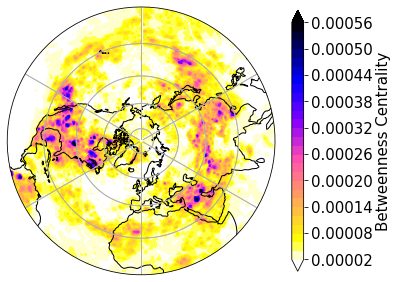

In [31]:
#due to the default threshold being too large for this use case, the private _threshold attribute is divided by 100
#smooths the connection plot 
hacked_proj = ccrs.NorthPolarStereo()
hacked_proj._threshold /= 100.

f = plt.figure(figsize=(6, 12))
proj = hacked_proj
   
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
    
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
 
gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None)  #to have smoother gridlines/latitude-lines
gl.n_steps = 90
    
#ax.set_title('Betweenness Centrality', fontsize=16)
ax.gridlines()
ax.set_extent([-180, 180, 90, 2], ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

clevs = [0.00002, 0.00004, 0.00006, 0.00008, 0.00010, 0.00012, 0.00014, 0.00016, 0.00018, 0.00020, 0.00022, 0.00024, 0.00026, 0.00028, 0.00030, 0.00032, 0.00034, 0.00036, 0.00038, 0.00040, 0.00042, 0.00044, 0.00046, 0.00048, 0.00050, 0.00052, 0.00054, 0.00056]
bc_map = ax.contourf(lon_unreduced, lat_unreduced, bc_interp, levels=clevs, cmap=plt.cm.gnuplot2_r, extend='both', transform=ccrs.PlateCarree())

cmap = plt.colorbar(bc_map, ax=ax, shrink=0.4)
cmap.set_label('Betweenness Centrality',size=15)
cmap.ax.tick_params(labelsize=15)

plt.show()
f.savefig(file_path + 'bc_taumax' + str(taumax) + '_' + perc + '_' + surr + '.png', bbox_inches='tight', dpi=f.dpi)

In [32]:
# bc is high for grid points, which lie on many shortest paths between any pair of grid points
# a high bc value indicates, that that grid point may be important for the propagation of extreme-slp

Betweenness centrality of a vertex $C_B(v)$ is defined as,

$C_B(v)=\sum_{s \neq v \neq t \epsilon V, s \neq t}  \frac{\sigma_{st}(v)}{\sigma_{st}}$

where $\sigma_{st}$ is the number of shortest paths from $s$ to $t$, and $\sigma_{st} (v)$ is the number of shortest paths from $s$ to $t$ that pass through a vertex $v$. This may be normalised by dividing through the number of pairs of vertices not including $v$, which is $(n-1)(n-2)/2$, for undirected graphs, or $(n-1)(n-2)$ for directed ones.

The algorithm used here is defined in [brandes-faster-2001], and has a complexity of $O(VE)$ for unweighted graphs and $O(VE+V(V+E)logV)$ for weighted graphs. The space complexity is $O(VE)$.

If the pivots parameter is given, the complexity will be instead $O(PE)$ for unweighted graphs and $O(PE+P(V+E)logV)$ for weighted graphs, where $P$ is the number of pivot vertices.

### Eigenvector Centrality

In [33]:
ev, vertex_ec = graph_tool.centrality.eigenvector(g)

In [34]:
ec = vertex_ec.a

In [35]:
ec_interp = interpolate_irregular_data(lon, lat, ec, lon_unreduced, lat_unreduced)

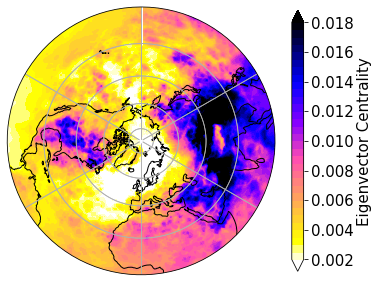

In [55]:
#due to the default threshold being too large for this use case, the private _threshold attribute is divided by 100
#smooths the connection plot 
hacked_proj = ccrs.NorthPolarStereo()
hacked_proj._threshold /= 100.

f = plt.figure(figsize=(6, 12))
proj = hacked_proj
   
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
    
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
 
gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None)  #to have smoother gridlines/latitude-lines
gl.n_steps = 90
    
#ax.set_title('Eigenvector Centrality', fontsize=16)
ax.gridlines()
ax.set_extent([-180, 180, 90, 2], ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

clevs = np.linspace(0.002,0.018,33).tolist()
ec_map = ax.contourf(lon_unreduced, lat_unreduced, ec_interp, levels=clevs, cmap=plt.cm.gnuplot2_r, extend='both', transform=ccrs.PlateCarree()) 

cmap = plt.colorbar(ec_map, ax=ax, shrink=0.4)
cmap.set_label('Eigenvector Centrality',size=15)
cmap.ax.tick_params(labelsize=15)

plt.show()
f.savefig(file_path + 'ec_taumax' + str(taumax) + '_' + perc + '_' + surr + '.png', bbox_inches='tight', dpi=f.dpi)

The eigenvector centrality $x$ is the eigenvector of the (weighted) adjacency matrix with the largest eigenvalue $\lambda$, i.e. it is the solution of

$Ax= \lambda x$,

where $A$ is the (weighted) adjacency matrix and $\lambda$ is the largest eigenvalue.

The algorithm uses the power method which has a topology-dependent complexity of $O(N \cdot \frac{-\log \epsilon}{\log|\lambda_{1}/\lambda_{2}|})$, where $N$ is the number of vertices, $\epsilon$ is the epsilon parameter, and $\lambda_1$ and $\lambda_2$ are the largest and second largest eigenvalues of the (weighted) adjacency matrix, respectively.

If enabled during compilation, this algorithm runs in parallel.

### Clustering Coefficient

In [37]:
vertex_cc = graph_tool.clustering.local_clustering(g, undirected=False)

In [38]:
cc = vertex_cc.a

In [39]:
cc_interp = interpolate_irregular_data(lon, lat, cc, lon_unreduced, lat_unreduced)

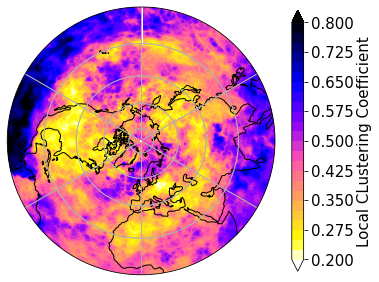

In [40]:
#due to the default threshold being too large for this use case, the private _threshold attribute is divided by 100
#smooths the connection plot 
hacked_proj = ccrs.NorthPolarStereo()
hacked_proj._threshold /= 100.

f = plt.figure(figsize=(6, 12))
proj = hacked_proj
   
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
    
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
 
gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None)  #to have smoother gridlines/latitude-lines
gl.n_steps = 90
    
#ax.set_title('Local CLustering Coefficient', fontsize=16)
ax.gridlines()
ax.set_extent([-180, 180, 90, 2], ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

clevs = np.linspace(0.2,0.8, 25).tolist()
cc_map = ax.contourf(lon_unreduced, lat_unreduced, cc_interp, levels=clevs, cmap=plt.cm.gnuplot2_r, extend='both', transform=ccrs.PlateCarree())

cmap = plt.colorbar(cc_map, ax=ax, shrink=0.4)
cmap.set_label('Local CLustering Coefficient',size=15)
cmap.ax.tick_params(labelsize=15)

plt.show()
f.savefig(file_path + 'lcc_taumax' + str(taumax) + '_' + perc + '_' + surr + '.png', bbox_inches='tight', dpi=f.dpi)

In [41]:
#cc measures the degree of spatial coherence in the distribution of extreme slp

The local clustering coefficient [watts-collective-1998] $c_i$ is defined as

$$c_i= \frac{|e_{jk}|}{k_i(k_i-1)} :v_j,v_k \epsilon N_i, e_{jk} \epsilon E$$

where $k_i$ is the out-degree of vertex $i$, and
$N_i={v_j:e_{ij} \epsilon E}$

is the set of out-neighbors of vertex $i$. For undirected graphs the value of $c_i$ is normalized as
$c'_i=2c_i$.

The implemented algorithm runs in $O(|V|<k^2>)$ time, where $<k^2>$ is second moment of the degree distribution.

If enabled during compilation, this algorithm runs in parallel.

### Mean Geographical Distance

In [42]:
#think about weighting of nodes for this measure
#maybe the solution is to consider nsi_average_path_length together with mgd

In [43]:
from numba import jit

#lat1 and lon1 scalars and lat2 and lon2 arrays
@jit(nopython=True)
def distance_np(lat1, lon1, lat2, lon2):  #haversine formula based on a spherical earth
    p = np.pi / 180    #Pi/180-radians
    a = 0.5 - np.cos((lat2 - lat1) * p) / 2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 12742 * np.arcsin(np.sqrt(a)) #2*R*asin...

In [44]:
lon_lat.shape

(16197, 2)

#### MGD

In [45]:
mgd = np.zeros(16197)
mgd_in = np.zeros(16197)
mgd_out = np.zeros(16197)

In [46]:
for i in range(compl_net.shape[0]):
    filter_arr = compl_net[i,:].astype(np.bool_)
    filter_arr2 = compl_net[:,i].astype(np.bool_)
    
    node = lon_lat[i]
    
    #coords of nodes that arr linked to node=lat_lon_arr[i]
    #lat, lon -> node=lat_lon_arr[i]
    tmp_lat = lon_lat[filter_arr][:,1]
    tmp_lon = lon_lat[filter_arr][:,0]
    #node=lat_lon_arr[i] -> lat2, lon2
    tmp_lat2 = lon_lat[filter_arr2][:,1]
    tmp_lon2 = lon_lat[filter_arr2][:,0]
    
    #calculating the distance in km
    distance = distance_np(node[1], node[0], tmp_lat, tmp_lon)
    distance2 = distance_np(node[1], node[0], tmp_lat2, tmp_lon2)
    distance_full = np.append(distance, distance2)
    
    #calculating the mean
    mgd[i] = distance_full.sum()/distance_full.shape[0]
    mgd_in[i] = distance.sum()/distance.shape[0]
    mgd_out[i] = distance2.sum()/distance2.shape[0]

In [47]:
mgd_interp = interpolate_irregular_data(lon, lat, mgd, lon_unreduced, lat_unreduced)

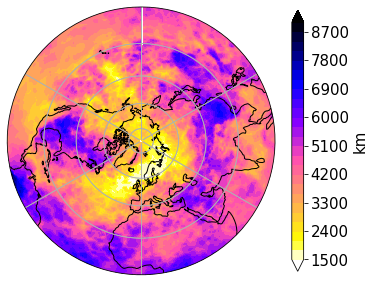

In [48]:
#due to the default threshold being too large for this use case, the private _threshold attribute is divided by 100
#smooths the connection plot 
hacked_proj = ccrs.NorthPolarStereo()
hacked_proj._threshold /= 100.

f = plt.figure(figsize=(6, 12))
proj = hacked_proj
   
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
    
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
 
gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None)  #to have smoother gridlines/latitude-lines
gl.n_steps = 90
    
#ax.set_title('Mean Geographical Distance', fontsize=16)
ax.gridlines()
ax.set_extent([-180, 180, 90, 2], ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

clevs = np.linspace(1500, 9000, 26).tolist()
mgd_in_map = ax.contourf(lon_unreduced, lat_unreduced, mgd_interp, cmap=plt.cm.gnuplot2_r, extend='both', levels=clevs, transform=ccrs.PlateCarree())

cmap = plt.colorbar(mgd_in_map, ax=ax, shrink=0.4)
cmap.set_label('km',size=15)
cmap.ax.tick_params(labelsize=15)

plt.show()
f.savefig(file_path + 'mgd_taumax' + str(taumax) + '_' + perc + '_' + surr + '.png', bbox_inches='tight', dpi=f.dpi)

In [49]:
#mean geographical distance of incoming and outgoing links at every node

# Network Divergence

$ \Delta S_i = S_{i}^{in} - S_{i}^{out} = \sum_{j=1}^{N} A_{ij} - \sum_{j=1}^{N} A_{ji}$

In [50]:
network_divergence = indegree - outdegree

In [51]:
network_divergence_interp = interpolate_irregular_data(lon, lat, network_divergence, lon_unreduced, lat_unreduced)

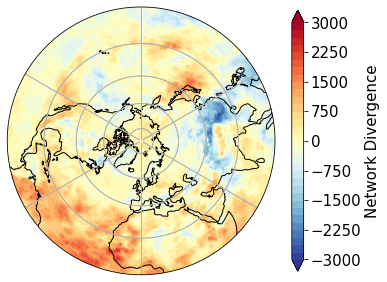

In [52]:
#due to the default threshold being too large for this use case, the private _threshold attribute is divided by 100
#smooths the connection plot 
hacked_proj = ccrs.NorthPolarStereo()
hacked_proj._threshold /= 100.

f = plt.figure(figsize=(6, 12))
proj = hacked_proj
   
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
 
gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None)  #to have smoother gridlines/latitude-lines
gl.n_steps = 90
    
#ax.set_title('Network Divergence', fontsize=16)
ax.gridlines()
ax.set_extent([-180, 180, 90, 2], ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

clevs = np.linspace(-3000,3000,33).tolist()
net_div_map = ax.contourf(lon_unreduced, lat_unreduced, network_divergence_interp, levels=clevs, cmap=plt.cm.RdYlBu_r, extend='both', transform=ccrs.PlateCarree())

cmap = plt.colorbar(net_div_map, ax=ax, shrink=0.4)
cmap.set_label('Network Divergence',size=15)
cmap.ax.tick_params(labelsize=15)

plt.show()
f.savefig(file_path + 'network_divergence_taumax' + str(taumax) + '_' + perc + '_' + surr + '.png', bbox_inches='tight', dpi=f.dpi)

In [53]:
# positive values indicate sinks of the directed newtwork and negative values indicate sources
# sinks in the context of extreme low slp are regions, where synchronized extreme low slp occurs within taumax days after it occured in several other regions
# sources in this context are regions, where synchronized extreme low slp occurs within taumax days before it occures in several other regions